# Определение стоимости автомобилей
___

Нам необходимо построить модель для определения стоимости автомобилей для сервиса по продаже автомобилей. Модель должна определить рыночную стоимость автомобиля на основании исторических данных: технические характеристики, комплектации и цены автомобилей. 

## Признаки

Датасет содержит следующие признаки:

- `DateCrawled` — дата скачивания анкеты из базы;


- `VehicleType` — тип автомобильного кузова;


- `RegistrationYear` — год регистрации автомобиля;


- `Gearbox` — тип коробки передач;


- `Power` — мощность (л.с.);


- `Model` — модель автомобиля;


- `Kilometer` — пробег (км);


- `RegistrationMonth` — месяц регистрации автомобиля;


- `FuelType` — тип топлива;


- `Brand` — марка автомобиля;


- `Repaired` — была машина в ремонте или нет;


- `DateCreated` — дата создания анкеты;


- `NumberOfPictures` — количество фотографий автомобиля;


- `PostalCode` — почтовый индекс владельца анкеты (пользователя);


- `LastSeen` — дата последней активности пользователя;


- `Price` - цена (евро).

## Содержание

1. Подготовка данных
2. Обучение моделей
3. Анализ моделей

## Подготовка данных

Импортируем необходимые для дальнейшего анализа библиотеки:

In [1]:
import time

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor, Pool, cv

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)

Прочитаем наш датасет и выведем основную информацию о нем:

In [4]:
data = pd.read_csv('autos.csv')

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [6]:
data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


Как видим, наш датасет содержит в себе 16 столбцов и 354369 строк.

Из общей информации о датасете видно, что в данных есть пропуски. Для дальнейшего анализа проведем предобработку данных с целью исключения дубликатов в данных, заполнении пропусков и исключении из данных аномальных значений.

Посмотрим, на столбцы с численными данными, построим графики и увидим, как они коррелируют между собой:

In [7]:
data.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


array([[<AxesSubplot:title={'center':'Price'}>,
        <AxesSubplot:title={'center':'RegistrationYear'}>,
        <AxesSubplot:title={'center':'Power'}>],
       [<AxesSubplot:title={'center':'Kilometer'}>,
        <AxesSubplot:title={'center':'RegistrationMonth'}>,
        <AxesSubplot:title={'center':'NumberOfPictures'}>],
       [<AxesSubplot:title={'center':'PostalCode'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

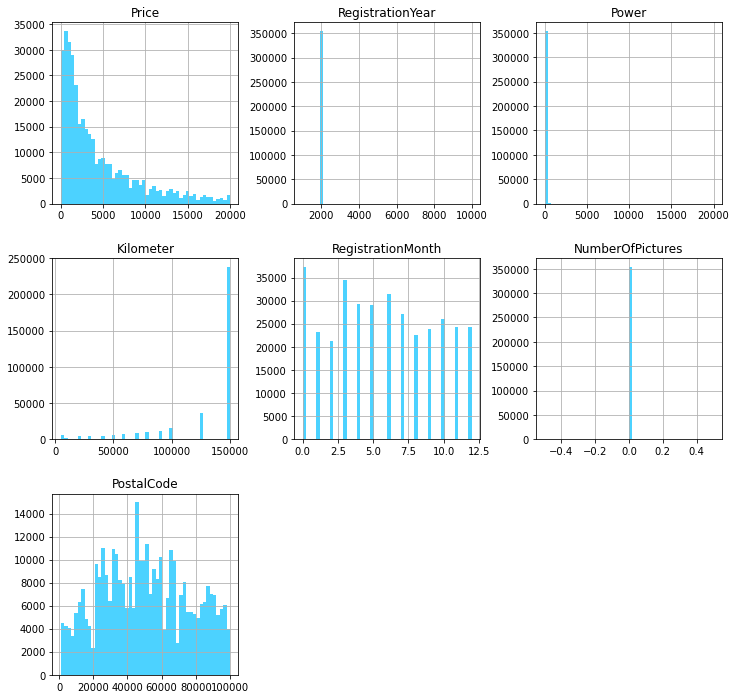

In [8]:
data.hist(figsize=(12, 12), bins=50, alpha=0.7, color='deepskyblue')

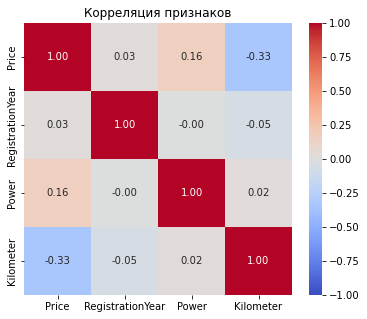

In [9]:
plt.figure(figsize=(6,5))
sns.heatmap(data[['Price', 'RegistrationYear', 'Power', 'Kilometer']].corr(), annot=True, fmt = '.2f', vmin=-1, vmax=1, center=0, cmap='coolwarm')
plt.title('Корреляция признаков')
plt.show()

Как видно из графиков, в данных присутствуют аномалии, распределение значений на графике выглядит неестественно.

Найдем количество дубликатов в нашем датасете:

In [10]:
data.duplicated().sum()

4

Отлично, всего 4 строки являются дублирующими, удалим их из наших данных:

In [11]:
data = data.drop_duplicates().reset_index(drop=True)

В наших данных есть столбцы, которые не влияют на стоимость автомобиля. Это столбцы:

- `DateCrawled` — дата скачивания анкеты из базы
- `RegistrationMonth` — месяц регистрации автомобиля
- `DateCreated` — дата создания анкеты
- `NumberOfPictures` — количество фотографий автомобиля
- `PostalCode` — почтовый индекс владельца анкеты (пользователя).

Если рассуждать, что автовладельцы с хорошими автомобилями делают более качественные фотографии и большее их число, то столбец `NumberOfPictures` мог бы влиять на стоимость автомобиля. Однако в нашем случае, он равен 0 значению, поэтому его мы тоже удаляем.

In [12]:
data = data.drop(['DateCrawled', 'RegistrationMonth', 'DateCreated', 'PostalCode', 'LastSeen', 'NumberOfPictures'], axis=1)

In [13]:
data.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
0,480,NaN,1993,manual,0,golf,150000,petrol,volkswagen,NaN
1,18300,coupe,2011,manual,190,NaN,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,NaN
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no


Отлично, мы сократили количество столбцов в наших данных до 10 штук и избавились от дубликатов, теперь перейдем к аномальных значениям и пропускам в данных. Посмотрим снова на распредление данных с помощью функции `describe`.

In [14]:
data.describe()

,Price,RegistrationYear,Power,Kilometer
count,354365.000000,354365.000000,354365.000000,354365.000000
mean,4416.679830,2004.234481,110.093816,128211.363989
std,4514.176349,90.228466,189.851330,37905.083858
min,0.000000,1000.000000,0.000000,5000.000000
25%,1050.000000,1999.000000,69.000000,125000.000000
50%,2700.000000,2003.000000,105.000000,150000.000000
75%,6400.000000,2008.000000,143.000000,150000.000000
max,20000.000000,9999.000000,20000.000000,150000.000000


Из таблицы видно, что в столбцах `Price`, `RegistrationYear` и `Power` присутствуют аномальные значения. Например, в столбцах `Price` и `Power` есть значения равные 0, а в столбце `RegistrationYear` минимальное значение составляет 1000, вряд ли в то время регистрировали машину... Тоже самое и с максимальными значениями, в столбце `RegistrationYear` максимумом является значение 9999, а в столбце `Power` 200000, вряд ли кто то в будущем продает ракету.

Для того, чтобы избавиться от явных аномалий, построим графики распределения значений - ящик с усами:

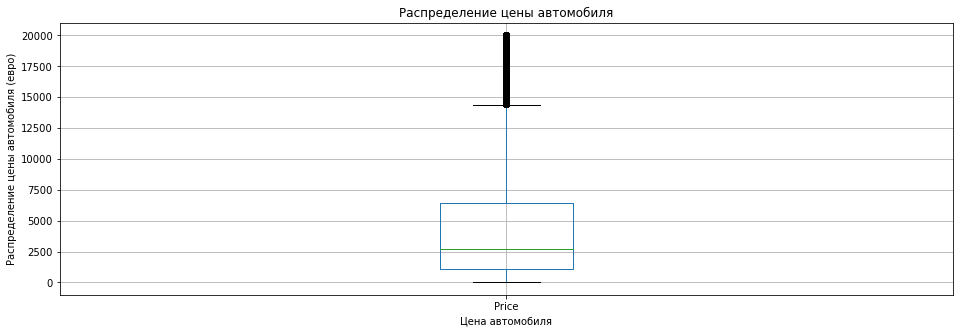

In [15]:
data.boxplot(column='Price', figsize=(16, 5))
plt.xlabel("Цена автомобиля")
plt.ylabel('Распределение цены автомобиля (евро)')
plt.title('Распределение цены автомобиля')
plt.show()

Как видно из графика, явными аномалиями являются автомобили со стоимостью выше 14000, но их единицы и это могут быть какие-то редкие, либо действительно дорогие автомобили, нас интересует больше нижний порог стоимости. Немало значений имеет стоимость автомобилей = 0 или близкой к нему, возможно кто-то действительно отдает свой автомобиль беспллатно, но это не поможет в нашем исследовании, поэтому уберем из данных автомобили со стоимостью меньше 50 евро:

In [16]:
data = data[data['Price'] > 50]

Посмотрим, как изменилось количество строк:

In [17]:
data.shape

(341615, 10)

В исходных данных было 354369 строк, теперь их насчитывает 341615, то есть мы исключили из датасета приблизительно 4,5% данных, пока в пределах допустимого.

Для определения границ года регистрации автомобилей посмотрим на данные создания и размещения анкеты:

In [18]:
display(pd.read_csv('autos.csv')[['DateCrawled', 'RegistrationYear', 'DateCreated']])

,DateCrawled,RegistrationYear,DateCreated
0,2016-03-24 11:52:17,1993,2016-03-24 00:00:00
1,2016-03-24 10:58:45,2011,2016-03-24 00:00:00
2,2016-03-14 12:52:21,2004,2016-03-14 00:00:00
3,2016-03-17 16:54:04,2001,2016-03-17 00:00:00
4,2016-03-31 17:25:20,2008,2016-03-31 00:00:00
...,...,...,...
354364,2016-03-21 09:50:58,2005,2016-03-21 00:00:00
354365,2016-03-14 17:48:27,2005,2016-03-14 00:00:00
354366,2016-03-05 19:56:21,2000,2016-03-05 00:00:00
354367,2016-03-19 18:57:12,1996,2016-03-19 00:00:00


Создание и размещение анкет содержит только 2016 год, значит верхняя граница года регистрации - 2016.

Нижний порог задан отметкой в 1000, это вероятно ошибка, поставим нижний диапазон в 1970 год, возможны редкие и коллекционные автомобили, поэтому не будем их выбрасывать из данных.

In [22]:
data = data[(data['RegistrationYear'] < 2017) & (data['RegistrationYear'] > 1970)]

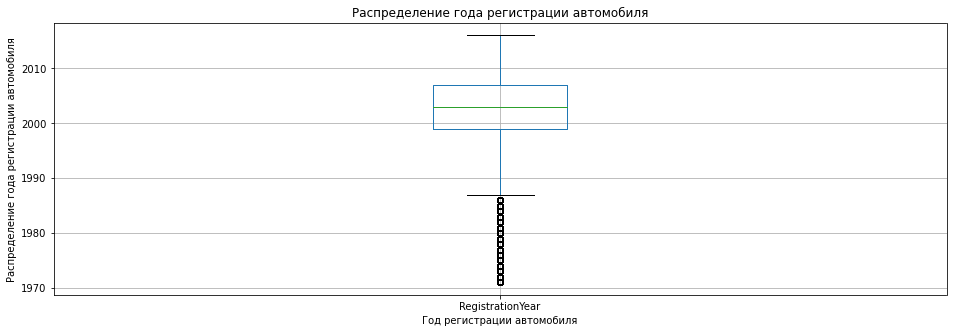

In [23]:
data.boxplot(column='RegistrationYear', figsize=(16, 5))
plt.xlabel("Год регистрации автомобиля")
plt.ylabel('Распределение года регистрации автомобиля')
plt.title('Распределение года регистрации автомобиля')
plt.show()

Аномалии все еще есть, но выбрасывать такой объем данных не будем.

Теперь глянем на распределение данных в столбце `Power`:

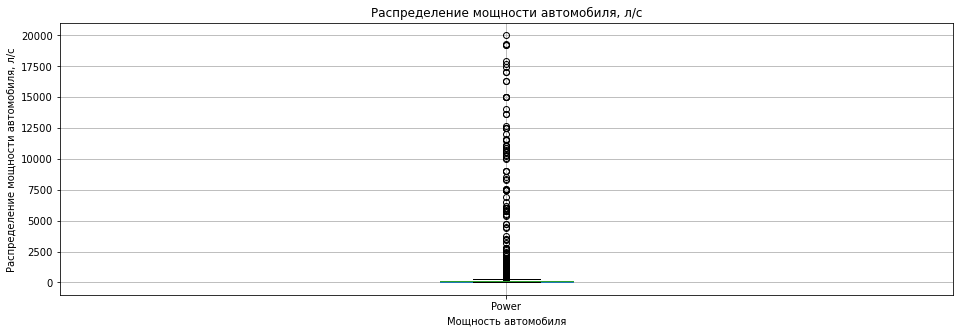

In [24]:
data.boxplot(column='Power', figsize=(16, 5))
plt.xlabel("Мощность автомобиля")
plt.ylabel('Распределение мощности автомобиля, л/с')
plt.title('Распределение мощности автомобиля, л/с')
plt.show()

Отсечем данные ниже отметки в 1000 л/с, чтобы график был более читаемым:

In [25]:
data = data[data['Power'] < 1000]

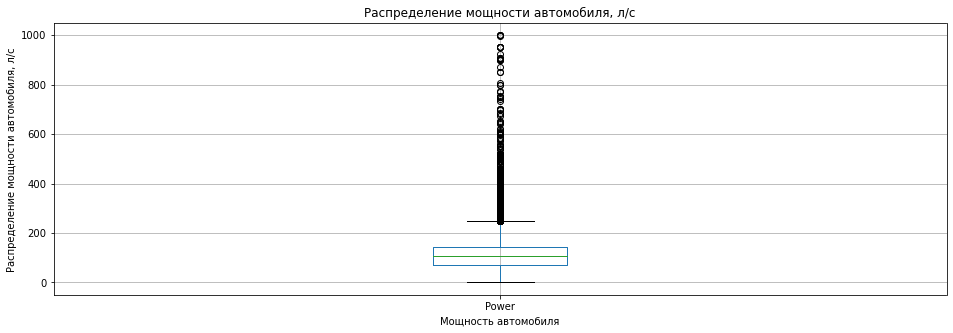

In [26]:
data.boxplot(column='Power', figsize=(16, 5))
plt.xlabel("Мощность автомобиля")
plt.ylabel('Распределение мощности автомобиля, л/с')
plt.title('Распределение мощности автомобиля, л/с')
plt.show()

Как видим, за пределами нормальных значений находятся автомобили с мощностью более 250 л/с, но такие машины существуют и выбрасывать их из датасета нелогично, поэтому примем за пороговое значение мощность автомобилей в 500 л/с. 
нулевые значения мы не выбрасываем, заполним их медианными значениями по бренду автомобиля.

In [27]:
data = data[data['Power'] < 500]

In [28]:
data.loc[data['Power'] == 0, 'Power'] = np.NaN
data['Power'] = data['Power'].fillna(
    data.groupby('Brand')['Power'].transform(lambda x: x.median() if x.median() else np.nan))

In [29]:
data.describe()

,Price,RegistrationYear,Power,Kilometer
count,326113.000000,326113.000000,326113.000000,326113.000000
mean,4619.131641,2002.785354,119.661892,128553.246881
std,4532.915453,6.323146,51.492728,37067.985859
min,55.000000,1971.000000,1.000000,5000.000000
25%,1200.000000,1999.000000,80.000000,125000.000000
50%,2950.000000,2003.000000,109.000000,150000.000000
75%,6650.000000,2007.000000,150.000000,150000.000000
max,20000.000000,2016.000000,490.000000,150000.000000


Теперь посмотрим на пропуски в данных:

In [30]:
data.isna().sum()

Price                   0
VehicleType         18877
RegistrationYear        0
Gearbox             14474
Power                   0
Model               14793
Kilometer               0
FuelType            22943
Brand                   0
Repaired            58149
dtype: int64

Пропуски имеются в столбцах:
- `VehicleType` 
- `Gearbox`
- `FuelType`
- `Repaired`

Посмотрим, какие данные содержат эти столбцы:

In [31]:
data['VehicleType'].value_counts()

sedan          88549
small          77469
wagon          63378
bus            28211
convertible    19679
coupe          15328
suv            11665
other           2957
Name: VehicleType, dtype: int64

Столбец `VehicleType` содержит типы кузова автомобиля и одним из вариантов является наименование `other`, заполним пропуски этим значением.

In [32]:
data['VehicleType'] = data['VehicleType'].fillna('other')

In [33]:
data['Gearbox'].value_counts()

manual    249146
auto       62493
Name: Gearbox, dtype: int64

Столбец `Gearbox` содержит всего два значения: автоматическая коробка передач и механическая. Заполнять их случайным образом бессмысленно, поэтому создадим новое наименование и назовем его `unknown`.

In [34]:
data['Gearbox'] = data['Gearbox'].fillna('unknown')

In [35]:
data['Model'].value_counts()

golf                  26586
other                 22389
3er                   18563
polo                  11937
corsa                 11484
                      ...  
serie_2                   3
rangerover                3
serie_3                   3
range_rover_evoque        2
serie_1                   1
Name: Model, Length: 250, dtype: int64

In [36]:
data['Model'].unique()

array(['golf', nan, 'grand', 'fabia', '3er', '2_reihe', 'c_max',
       '3_reihe', 'passat', 'navara', 'polo', 'twingo', 'a_klasse',
       'scirocco', '5er', 'arosa', 'other', 'civic', 'transporter',
       'punto', 'e_klasse', 'clio', 'kadett', 'kangoo', 'one', 'fortwo',
       '1er', 'b_klasse', 'signum', 'astra', 'a8', 'jetta', 'fiesta',
       'c_klasse', 'micra', 'vito', 'sprinter', '156', 'escort',
       'forester', 'xc_reihe', 'scenic', 'a4', 'ka', 'a1', 'insignia',
       'combo', 'focus', 'tt', 'corsa', 'a6', 'jazz', 'omega', 'slk',
       '7er', '80', '147', '100', 'z_reihe', 'sorento', 'v40', 'ibiza',
       'mustang', 'eos', 'touran', 'getz', 'a3', 'almera', 'megane',
       'lupo', 'r19', 'caddy', 'mondeo', 'cordoba', 'colt', 'impreza',
       'vectra', 'berlingo', 'tiguan', 'sharan', '6_reihe', 'c4', 'panda',
       'up', 'i_reihe', 'ceed', '5_reihe', 'yeti', 'octavia', 'zafira',
       'mii', 'rx_reihe', '6er', 'modus', 'fox', 'matiz', 'beetle', 'c1',
       'rio', 'to

Моделей машин достаточно много, но и тут есть значение `other`, этим же значением и заполним пропуски.

In [37]:
data['Model'] = data['Model'].fillna('other')

In [38]:
data['FuelType'].value_counts()

petrol      202665
gasoline     94541
lpg           5004
cng            526
hybrid         219
other          131
electric        84
Name: FuelType, dtype: int64

В столбце типа топлива также присутствует наименование `other`, сюда и запишем наши пропуски. 

In [39]:
data['FuelType'] = data['FuelType'].fillna('other')

In [40]:
data['Repaired'].value_counts()

no     235583
yes     32381
Name: Repaired, dtype: int64

Столбец `Repaired` содержит данные о том, была ли машина в ремонте или нет. Думаю речь идет про ремонт после аварий. Заполним пропуски значением `no`. Считаю, что если человек не заполнил графу наличия ремонта, то это потому что его и правда не было, а не потому что он хочет что-то скрыть.

In [41]:
data['Repaired'] = data['Repaired'].fillna('no')

Посмотрим на пропуски:

In [42]:
data.isna().sum()

Price               0
VehicleType         0
RegistrationYear    0
Gearbox             0
Power               0
Model               0
Kilometer           0
FuelType            0
Brand               0
Repaired            0
dtype: int64

Пропусков нет, идем дальше!

In [43]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 326113 entries, 0 to 354364
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Price             326113 non-null  int64  
 1   VehicleType       326113 non-null  object 
 2   RegistrationYear  326113 non-null  int64  
 3   Gearbox           326113 non-null  object 
 4   Power             326113 non-null  float64
 5   Model             326113 non-null  object 
 6   Kilometer         326113 non-null  int64  
 7   FuelType          326113 non-null  object 
 8   Brand             326113 non-null  object 
 9   Repaired          326113 non-null  object 
dtypes: float64(1), int64(3), object(6)
memory usage: 27.4+ MB


Переведем столбцы типа `object` к типу `category`, а столбец типа `float64` к типу `int64`:

In [44]:
categorial_columns = ['VehicleType','Gearbox', 'Model','FuelType', 'Brand', 'Repaired']
data[categorial_columns] = data[categorial_columns].astype('category')
data['Power'] = data['Power'].astype('int64')

In [45]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 326113 entries, 0 to 354364
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype   
---  ------            --------------   -----   
 0   Price             326113 non-null  int64   
 1   VehicleType       326113 non-null  category
 2   RegistrationYear  326113 non-null  int64   
 3   Gearbox           326113 non-null  category
 4   Power             326113 non-null  int64   
 5   Model             326113 non-null  category
 6   Kilometer         326113 non-null  int64   
 7   FuelType          326113 non-null  category
 8   Brand             326113 non-null  category
 9   Repaired          326113 non-null  category
dtypes: category(6), int64(4)
memory usage: 14.6 MB


Напишем два ColumnTransformer'а. transformer - для 'деревянных' моделей; применяется порядковое кодирование категориальных признаков, численные не меняются. transformer_linear - для линейной регрессии; для категориальных признаков - прямое кодирование, для численных - масштабирование.

In [47]:
num_columns = ['RegistrationYear', 'Power', 'Kilometer']
cat_columns = ['VehicleType','Gearbox', 'Model','FuelType', 'Brand', 'Repaired']

transformer = ColumnTransformer(
    [("enc", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1), cat_columns)],
    remainder='passthrough'
)

transformer_linear = ColumnTransformer(
            [("ohe", OneHotEncoder(drop = 'first', handle_unknown = 'ignore', sparse=False), cat_columns),
            ("scaler", StandardScaler(), num_columns)],
            remainder='passthrough'
)

Данные готовы к обучению моделей.

## Обучение моделей

### Подготовка данных

Разделим наш датасет на обучающие и тестовые данные:

In [48]:
features_train, features_test, target_train, target_test = train_test_split(
    data.drop('Price', axis=1), data.Price, test_size=0.25, random_state=12345)

In [49]:
print('Размеры получившихся выборок: ')
print('Обучающая:', len(features_train))
print('Тестовая:', len(features_test))

Размеры получившихся выборок: 
Обучающая: 244584
Тестовая: 81529


In [50]:
cat_features = ['VehicleType','Gearbox', 'Model','FuelType', 'Brand', 'Repaired']

Создадим функцию для поиска лучших гиперпараметров:

In [51]:
def fit_model(estimator, param_grid, x, y):
    model = GridSearchCV(estimator=estimator, 
                            param_grid=param_grid, 
                            #n_jobs=-1, 
                            cv=4,
                            scoring='neg_root_mean_squared_error')

    model.fit(features_train, target_train)

    best_index = model.best_index_
    best_rmse = round(model.cv_results_['mean_test_score'][best_index], 1)

    print(f"Best RMSE: {abs(best_rmse)}")
    print(f"Best params: {model.best_params_}")

    return model.best_estimator_

### Модель случайного леса

In [52]:
%%time

rf_estimator = Pipeline([
    ('transformer', transformer),
    ('rf', RandomForestRegressor(random_state=12345, n_jobs=-1))
])

CPU times: user 76 µs, sys: 1 µs, total: 77 µs
Wall time: 82.3 µs


In [53]:
%%time

rf_param_grid =  {
    'rf__n_estimators': list(range(50, 151, 50)),
    "rf__max_depth": list(range(15, 31, 5)),
}

CPU times: user 11 µs, sys: 1 µs, total: 12 µs
Wall time: 15.7 µs


In [54]:
%%time

rf_best_model = fit_model(
estimator=rf_estimator,
param_grid=rf_param_grid,
x=features_train,
y=target_train
)

Best RMSE: 1605.2
Best params: {'rf__max_depth': 20, 'rf__n_estimators': 150}
CPU times: user 4min 9s, sys: 59.4 s, total: 5min 9s
Wall time: 6min 31s


Лучшими гиперпараметрами модели случайного леса являются:
- глубина дерева = 20;
- количество деревьев = 150.

Показатель метрики RMSE составил 1605,2.

### Модель линейной регрессии

Для обучения модельной регрессии нам необходимо поделить обучающую выборку на обучающую и валидационную:

In [55]:
features_train_1, features_valid, target_train_1, target_valid = train_test_split(
    features_train, target_train, test_size=0.25, random_state=12345)

In [56]:
%%time

lr_estimator = Pipeline([
    ('tranformer', transformer_linear),
    ('lr', LinearRegression())
])

lr_estimator.fit(features_train_1, target_train_1)
rmse = mean_squared_error(target_valid, lr_estimator.predict(features_valid)) ** 0.5
print(f"RMSE: {rmse:.1f}")

RMSE: 2564.8
CPU times: user 7.51 s, sys: 2.74 s, total: 10.2 s
Wall time: 3.67 s


Показатель RMSE составил колоссальные 2564.8.

### Модель LGBMRegressor

In [57]:
features_train_lgbm = features_train.copy()
features_train_lgbm[cat_columns] = features_train_lgbm[cat_columns].astype("category")

In [58]:
%%time

lgbm_estimator = LGBMRegressor(random_state=12345, n_jobs=-1)

lgbm_param_grid = {
    "n_estimators": range(250, 351, 50), 
    "max_depth": range(5, 17, 3),
    'learning_rate': [0.1, 0.2]
}

lgbm_best_model = fit_model(
    estimator=lgbm_estimator,
    param_grid=lgbm_param_grid,
    x=features_train,
    y=target_train
)

Best RMSE: 1553.9
Best params: {'learning_rate': 0.2, 'max_depth': 14, 'n_estimators': 350}
CPU times: user 17min 2s, sys: 2min 51s, total: 19min 53s
Wall time: 3min 4s


Лучшими гиперпараметрами модели LGBMRegressor являются:
- метрика `learning_rate` = 0.2;
- глубина дерева = 14;
- количество деревьев = 350.

Показатель метрики RMSE составил 1553.9.

### Модель CatBoostRegressor

In [59]:
%%time

catboost_estimator = CatBoostRegressor(random_state=12345, verbose=False, cat_features=cat_columns)

catboost_param_grid = {
    "iterations": range(200, 301, 100),
    "learning_rate": [0.15, 0.20],
    "depth": range(12, 16, 3)
}

catboost_best_model = fit_model(
    estimator=catboost_estimator,
    param_grid=catboost_param_grid,
    x=features_train,
    y=target_train
)

Best RMSE: 1549.7
Best params: {'depth': 15, 'iterations': 300, 'learning_rate': 0.15}
CPU times: user 3h 5min 27s, sys: 6min 46s, total: 3h 12min 13s
Wall time: 36min 46s


Лучшими параметрами модели CatBoostRegressor являются: 
- метрика `learning_rate` = 0.15;
- глубина дерева = 15;
- количество деревьев = 300.

Показатель метрики RMSE составил 1549.7.

Теперь можем провести анализ моделей для выбора лучшей.

## Анализ моделей

In [61]:
features_train_transformed = transformer.fit_transform(features_train) 
features_train_l_transformed = transformer_linear.fit_transform(features_train)

### Модель случайного леса

In [62]:
%%time
rf = RandomForestRegressor(
    n_estimators=150,
    max_depth=20,
    random_state=12345,
    n_jobs=-1).fit(features_train_transformed, target_train)

CPU times: user 1min 22s, sys: 1.04 s, total: 1min 23s
Wall time: 11.8 s


In [63]:
%%time
rf.predict(features_train_transformed)

CPU times: user 10.9 s, sys: 281 ms, total: 11.1 s
Wall time: 1.47 s


array([13473.65916326,  4963.06360802,  2530.16758695, ...,
         540.31772997, 16562.58262072,  3804.65739833])

### Модель линейной регрессии

In [64]:
%%time
lr = LinearRegression().fit(features_train_l_transformed, target_train)

CPU times: user 9.69 s, sys: 2.54 s, total: 12.2 s
Wall time: 3.65 s


In [65]:
%%time
lr.predict(features_train_l_transformed)

CPU times: user 698 ms, sys: 287 ms, total: 985 ms
Wall time: 137 ms


array([ 5078.85118074,  6062.72884647,  2461.33357871, ...,
        -707.71954313, 12540.19367567,  4416.008834  ])

### Модель LGBMRegressor

In [66]:
%%time
lgbm = LGBMRegressor(
    learning_rate=0.2,
    max_depth=14,
    n_estimators=350,
    random_state=12345,
    n_jobs=-1).fit(features_train_lgbm, target_train)

CPU times: user 7.21 s, sys: 711 ms, total: 7.92 s
Wall time: 1.11 s


In [67]:
%%time
lgbm.predict(features_train_lgbm)

CPU times: user 3.88 s, sys: 67.1 ms, total: 3.95 s
Wall time: 523 ms


array([ 9433.42518603,  6389.55841853,  2661.28409609, ...,
         399.09109449, 15547.40804114,  4290.70524455])

### Модель CatBoostRegressor

In [68]:
%%time
cat = CatBoostRegressor(
    depth=15,
    iterations=300,
    learning_rate=0.15,
    random_state=12345,
    cat_features=cat_columns,
    verbose=False).fit(features_train, target_train)

CPU times: user 9min 55s, sys: 26.7 s, total: 10min 21s
Wall time: 2min 1s


In [69]:
%%time
cat.predict(features_train)

CPU times: user 2.52 s, sys: 28.9 ms, total: 2.55 s
Wall time: 448 ms


array([10323.13926189,  5731.6448906 ,  2454.71247289, ...,
         448.59613113, 16219.97748772,  4417.84974268])

Соберем в одну таблицу время обучения модели, время предсказания и показатель `RMSE`:

In [71]:
values = [[11.8, 1.47, 1605.2],
         [3.65, 0.137, 2564.8],
         [1.11, 0.523, 1553.9],
         [121, 0.448, 1549.7]]
table = pd.DataFrame(data=values, 
                     columns=['Время обучения, с', 'Время предсказания, с', 'rmse'], 
                     index=['RandomForestRegressor','LinearRegressor', 'LGBMRegressor', 'CatBoostRegressor']
                    )
display(table)

,"Время обучения, с","Время предсказания, с",rmse
RandomForestRegressor,11.80,1.470,1605.2
LinearRegressor,3.65,0.137,2564.8
LGBMRegressor,1.11,0.523,1553.9
CatBoostRegressor,121.00,0.448,1549.7


Наилучший результат по времени и по показателю `RMSE` показала модель CatBoostRegressor, следовательно на ней мы и опробуем тестовые данные:

In [72]:
features_test_catboost = features_test.copy()
features_test_catboost[cat_columns] = features_test_catboost[cat_columns].astype("category")

rmse = mean_squared_error(target_test, catboost_best_model.predict(features_test_catboost)) ** 0.5
print(f"RMSE на тестовой: {rmse:.1f}")

RMSE на тестовой: 1532.2


Показатель `RMSE` составляет 1532.2

# Вывод

Задачей являлось разработать модель обучения, которая будет помогать определить рыночную стоимость автомобиля.

При работе над проектом был проведен анализ представленных данных, исключены данные, обработаны пропуски и аномалии.

Обучены четыре разные модели обучения для выявления лучшей по следующим показателям:
- качество предсказания;
- время обучения модели;
- время предсказания модели.

Лучшей моделью по данным показателям является CatBoostRegressor, показатель качества предсказания составил 1532.2, что ниже нашего порогового значения.